# Explore the input data for flood models

In [3]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [5]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [68]:
np.array(sorted([d.name for d in (data_dir / "features/one_timestep_forecast").glob("*")]))

array(['.ipynb_checkpoints', '2020_04_15:094101_data.nc_',
       '2020_04_15:122556_data.nc_', '2020_04_15:133254_data.nc_',
       'data.nc', 'normalizing_dict.pkl', 'test', 'train'], dtype='<U26')

In [69]:
np.array(sorted([d.name for d in (data_dir / "features/static").glob("*")]))

array(['.ipynb_checkpoints', '2020_04_07:190519_data.nc_',
       '2020_04_08:082808_data.nc_', '2020_04_09:170724_data.nc_',
       '2020_04_13:074136_data.nc_', '2020_04_13:074853_data.nc_',
       '2020_04_13:075144_data.nc_', '2020_04_13:090915_data.nc_',
       '2020_04_13:092228_data.nc_', '2020_04_13:140530_data.nc_',
       '2020_04_13:151607_data.nc_', '2020_04_13:155241_data.nc_',
       '2020_04_13:163836_data.nc_', '2020_04_14:141442_data.nc_',
       '2020_04_14:150238_data.nc_', '2020_04_15:094109_data.nc_',
       '2020_04_15:122558_data.nc_', '2020_04_15:133256_data.nc_',
       'data.nc', 'normalizing_dict.pkl'], dtype='<U26')

In [7]:
np.array(sorted([d.name for d in (data_dir / "models/").glob("*timestep*")]))

array(['2020_04_07:171723_one_timestep_forecast',
       '2020_04_13:090536_one_timestep_forecast',
       '2020_04_13:091211_one_timestep_forecast',
       '2020_04_13:144437_one_timestep_forecast',
       '2020_04_13:155432_one_timestep_forecast',
       '2020_04_13:171738_one_timestep_forecast',
       '2020_04_15:095841_one_timestep_forecast',
       '2020_04_15:124352_one_timestep_forecast',
       '2020_04_15:135101_one_timestep_forecast', 'one_timestep_forecast',
       'one_timestep_forecast_19epoch_static',
       'one_timestep_forecast_1epoch',
       'one_timestep_forecast_1epoch_static',
       'one_timestep_forecast_20epoch',
       'one_timestep_forecast_20epoch_static',
       'one_timestep_forecast_ORIGINAL'], dtype='<U39')

In [61]:
EXPERIMENT =      '2020_04_15:135101_one_timestep_forecast'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_spec'
N_EPOCHS = 100

DATA_FILE = "2020_04_15:094101_data.nc_"
STATIC_DATA_FILE = 'data.nc'

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in data

In [62]:
# read in model
ealstm = load_model(data_dir / f'models/{EXPERIMENT}/ealstm/model.pt')

Using the Dynamic DataLoader
	Target Var: discharge_spec
	Test Years: [2011 2012 2013 2014 2015 2016]


In [63]:
# read in model predictions
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)
ealstm_pred['station_id'] = ealstm_pred['station_id'].astype(int)

Reading all .nc files from: data/models/2020_04_15:135101_one_timestep_forecast/ealstm
All datasets loaded. Now combining ...


In [64]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static_ds = all_static.drop(ealstm.static_ignore_vars)

ds['station_id'] = ds['station_id'].astype(int)
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    pet                  (time, station_id) float64 ...
    temperature          (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    humidity             (time, station_id) float64 ...
    shortwave_rad        (time, station_id) float64 ...
    longwave_rad         (time, station_id) float64 ...
    windspeed            (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [65]:
# get the observed y_test
times = ealstm_pred.time.values
station_ids = ealstm_pred.station_id.values

In [66]:
print(f"\n** N Stations ignored: {all_static.station_id.shape[0] - len(station_ids)} **\n")

ignored_stations = sorted([st for st in all_static.station_id.values if st not in station_ids])
names = all_static.sel(station_id=ignored_stations)['gauge_name'].values
# print(np.array([f"{i}: {nm}" for i, nm in zip(ignored_stations, names)]), "\n\n")


** N Stations ignored: 658 **



In [15]:
# Get the predicted and true data
# 'target_var_original' 'discharge_spec'
y_test = ds[TARGET_VAR].sel(station_id=station_ids).sel(time=times)
true_da = y_test

# pred_da = np.exp(ealstm_pred['preds']) - 0.001
pred_da = ealstm_pred['preds']

print(f"{true_da.mean().values}, {true_da.std().values}")
print(f"{pred_da.mean().values}, {pred_da.std().values}")

# check that they are more or less correctly transformed
# assert np.isclose(true_da.mean().values, pred_da.mean().values, atol=0.1)
# assert np.isclose(true_da.std().values, pred_da.std().values, atol=0.4)

print('\n')
display("pred_da coordinates", pred_da.coords)
display("true_da coordinates", true_da.coords)

0.0014188763793992218, 1.1003196832674753
-0.11203763633966446, 1.0179330110549927




'pred_da coordinates'

Coordinates:
  * station_id  (station_id) int64 12002 15006 27009 27034 ... 54057 71001 84013
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

'true_da coordinates'

Coordinates:
  * station_id  (station_id) int64 12002 15006 27009 27034 ... 54057 71001 84013
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [16]:
# join the true and the pred data into one pd.DataFrame
df = (
    join_true_pred_da(
        true_da, pred_da
    ).to_dataframe()
    .reset_index()
    .set_index('time')
)

df.head()

,station_id,discharge_spec,preds
time,,,
2011-01-01,12002,1.188148,0.634989
2011-01-02,12002,0.647627,0.562341
2011-01-03,12002,0.483043,0.487298
2011-01-04,12002,0.458058,0.533733
2011-01-05,12002,0.470628,0.651755


# Run correlations between X variables and y

In [73]:
norm_ds = []
ds = ds.drop('pet')
for variable in list(ds.data_vars):    
    mean = ealstm.normalizing_dict[variable]['mean']
    std = ealstm.normalizing_dict[variable]['std']
    norm_ds.append((ds[variable] - mean) / std)

norm_ds = xr.merge(norm_ds)

In [74]:
norm_df = norm_ds.to_dataframe().drop(columns='target_var_original')
norm_df = norm_df[sorted(norm_df.columns)]

In [75]:
corr = norm_df.corr()
mask = np.triu(corr)

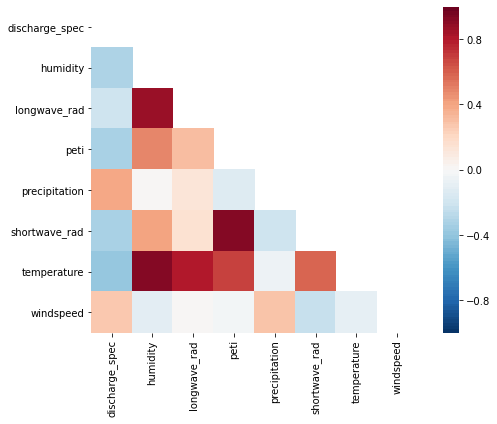

In [77]:
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette('RdBu_r', 100),
    square=True,
    mask=mask,
    ax=ax
)
ax.set_title('')

In [80]:
static_df = static_ds.to_dataframe()
corr = static_df.corr()
mask = np.triu(corr)

Text(0.5, 1.0, '')

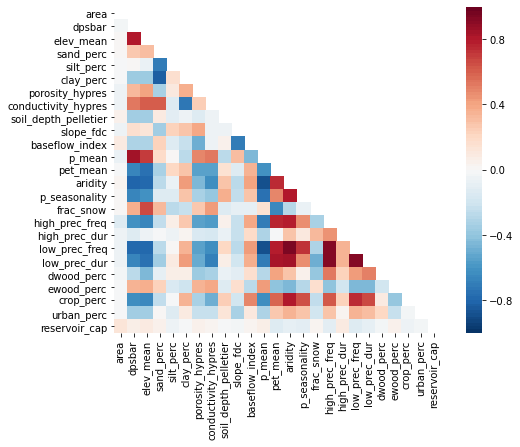

In [81]:
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette('RdBu_r', 100),
    square=True,
    mask=mask,
    ax=ax
)
ax.set_title('')